# Chapter 7: Question Answering

## Building a Review-Based QA System

### The Dataset

> SubjQA is a question answering dataset that focuses on subjective (as opposed to factual) questions and answers. The dataset consists of roughly 10,000 questions over reviews from 6 different domains: books, movies, grocery, electronics, TripAdvisor (i.e. hotels), and restaurants. Each question is paired with a review and a span is highlighted as the answer to the question (with some questions having no answer). Moreover, both questions and answer spans are assigned a subjectivity label by annotators. Questions such as "How much does this product weigh?" is a factual question (i.e., low subjectivity), while "Is this easy to use?" is a subjective question (i.e., high subjectivity).
>
> In short, SubjQA provides a setting to study how well extractive QA systems perform on finding answer that are less factual and to what extent modeling subjectivity can improve the performance of QA systems.

Let's download the `subjqa` dataset and poke around a bit.

See the [Dataset card fof `subjqa` at HF](https://huggingface.co/datasets/subjqa).

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Found cached dataset subjqa (/home/kashiwapoodle/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import json

#print(subjqa["train"]["answers"][1])
print(json.dumps(
    subjqa["train"][1], 
    indent=2
))

{
  "domain": "electronics",
  "nn_mod": "harsh",
  "nn_asp": "high",
  "query_mod": "not strong",
  "query_asp": "bass",
  "q_reviews_id": "7c46670208f7bf5497480fbdbb44561a",
  "question_subj_level": 1,
  "ques_subj_score": 0.5,
  "is_ques_subjective": false,
  "review_id": "ce76793f036494eabe07b33a9a67288a",
  "id": "d476830bf9282e2b9033e2bb44bbb995",
  "title": "B00001P4ZH",
  "context": "To anyone who hasn't tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they're good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer's sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they're very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I

You see how `answers` has children `text`, `answer_start`, `answer_subj_level`, etc. 

If you want to explode the children of `answers` into their own columns, then use [`datasets.flatten`](https://huggingface.co/docs/datasets/process#flatten):

In [4]:
subjqa["validation"].flatten().features.to_dict()

{'domain': {'dtype': 'string', '_type': 'Value'},
 'nn_mod': {'dtype': 'string', '_type': 'Value'},
 'nn_asp': {'dtype': 'string', '_type': 'Value'},
 'query_mod': {'dtype': 'string', '_type': 'Value'},
 'query_asp': {'dtype': 'string', '_type': 'Value'},
 'q_reviews_id': {'dtype': 'string', '_type': 'Value'},
 'question_subj_level': {'dtype': 'int64', '_type': 'Value'},
 'ques_subj_score': {'dtype': 'float32', '_type': 'Value'},
 'is_ques_subjective': {'dtype': 'bool', '_type': 'Value'},
 'review_id': {'dtype': 'string', '_type': 'Value'},
 'id': {'dtype': 'string', '_type': 'Value'},
 'title': {'dtype': 'string', '_type': 'Value'},
 'context': {'dtype': 'string', '_type': 'Value'},
 'question': {'dtype': 'string', '_type': 'Value'},
 'answers.text': {'feature': {'dtype': 'string', '_type': 'Value'},
  '_type': 'Sequence'},
 'answers.answer_start': {'feature': {'dtype': 'int32', '_type': 'Value'},
  '_type': 'Sequence'},
 'answers.answer_subj_level': {'feature': {'dtype': 'int64', '_t

In [5]:
import pandas as pd

dfs = { 
    split: dset.to_pandas() 
    for split, dset 
    in subjqa.flatten().items() 
}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Note that the `subjqa` dataset is quite small, but entirely in keeping with real-world scenarios since labelled data is very hard to find and expensive to create (you should know that!).

Now that we have transformed the `dataset` into `pandas.DataFrame`, we can use things like [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to have a closer look...

In [6]:
qa_cols = [
    "title",
    "question",
    "answers.text",
    "answers.answer_start",
    "context"
]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

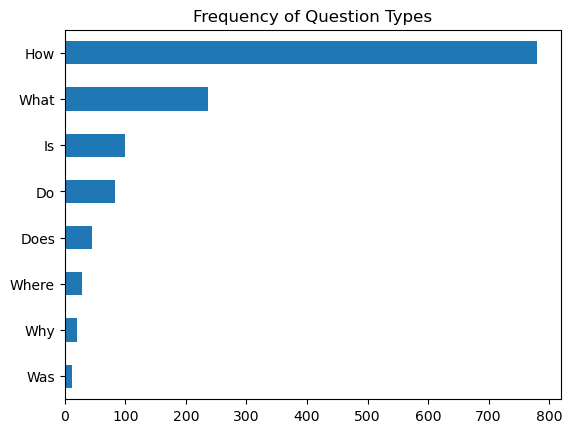

In [8]:
import matplotlib.pyplot as plt

counts = {}

question_types = [
    "What",
    "How",
    "Is",
    "Does",
    "Do",
    "Was",
    "Where",
    "Why"
]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [9]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)["question"]
    ):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Extracting Answers from Text